# Libraries

In [20]:
import gym
import random
import ray
import tensorflow as tf
import utils
from ray.rllib.algorithms.ppo import PPO
from ray.rllib.models import ModelCatalog
from ray.rllib.models.tf.tf_modelv2 import TFModelV2
from environments.knapsack import KnapsackEnv

# Define Custom Model
* Multiple Inputs are concatenated
* Action Mask is applied

In [21]:
class PPOCustomModel(TFModelV2):
    def __init__(self, obs_space, action_space, num_outputs, model_config, name):
        orig_space = getattr(obs_space, "original_space", obs_space)

        assert (
                isinstance(orig_space, gym.spaces.Dict)
                and "action_mask" in orig_space.spaces
                and "observations" in orig_space.spaces
        )

        super().__init__(
            obs_space=obs_space,
            action_space=action_space,
            num_outputs=num_outputs,
            model_config=model_config,
            name=name
        )

        weight_inputs = tf.keras.layers.Input(shape=orig_space['observations']['observation_weights'].shape, name='observation_weights')
        value_inputs = tf.keras.layers.Input(shape=orig_space['observations']['observation_values'].shape, name='observation_values')
        knapsack_inputs = tf.keras.layers.Input(shape=orig_space['observations']['observation_knapsack'].shape, name='observation_knapsack')
        inputs = tf.keras.layers.Concatenate(axis=-1)([weight_inputs, value_inputs, knapsack_inputs])
        x = tf.keras.layers.Dense(units=256, activation='tanh', name='hidden_1')(inputs)
        x = tf.keras.layers.Dense(units=256, activation='tanh', name='hidden_2')(x)
        policy_out = tf.keras.layers.Dense(units=num_outputs, name='policy_out')(x)
        value_out = tf.keras.layers.Dense(units=1, name='value_out')(x)
        self.base_model = tf.keras.Model([weight_inputs, value_inputs, knapsack_inputs], [policy_out, value_out])

    def forward(self, input_dict, state, seq_lens):
        action_mask = input_dict['obs']['action_mask']
        observations = input_dict['obs']['observations']

        model_out, self._value_out = self.base_model(observations)
        masked_model_out = model_out + tf.maximum(tf.math.log(action_mask), tf.float32.min)
        return masked_model_out, state

    def value_function(self):
        return tf.reshape(self._value_out, [-1])

# Train Custom Masked Model

2023-01-05 11:52:06,427	INFO worker.py:1538 -- Started a local Ray instance.
2023-01-05 11:52:07,897	WARNING deprecation.py:47 -- DeprecationWarning: `algo = Algorithm(env='<class 'environments.knapsack.KnapsackEnv'>', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('<class 'environments.knapsack.KnapsackEnv'>').build()` instead. This will raise an error in the future!
(RolloutWorker pid=10040) 2023-01-05 11:52:12,406	WARNING env.py:147 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2023-01-05 11:52:16,223	WARNING util.py:66 -- Install gputil for GPU system monitoring.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 observation_weights (InputLaye  [(None, 10)]        0           []                               
 r)                                                                                               
                                                                                                  
 observation_values (InputLayer  [(None, 10)]        0           []                               
 )                                                                                                
                                                                                                  
 observation_knapsack (InputLay  [(None, 1)]         0           []                               
 er)                                                                                          

(RolloutWorker pid=10040) C:\Users\kochlis\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: overflow encountered in reduce
(RolloutWorker pid=10040)   ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)
C:\Users\kochlis\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\core\_methods.py:179: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


Iteration: 0, Average Returns: 14.8
Iteration: 1, Average Returns: 19.0
Iteration: 2, Average Returns: 16.2
Iteration: 3, Average Returns: 21.0
Iteration: 4, Average Returns: 22.8
Iteration: 5, Average Returns: 24.6
Iteration: 6, Average Returns: 21.8
Iteration: 7, Average Returns: 24.8
Iteration: 8, Average Returns: 23.8
Iteration: 9, Average Returns: 26.0


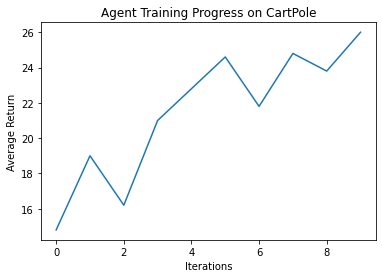

[14.8, 19.0, 16.2, 21.0, 22.8, 24.6, 21.8, 24.8, 23.8, 26.0]

In [22]:
ray.shutdown()
ray.init()
ModelCatalog.register_custom_model("ppo_model", PPOCustomModel)
tf.random.set_seed(seed=0)
random.seed(0)
agent = PPO(env=KnapsackEnv, config={
    'env_config': {},
    'model': {
        'vf_share_layers': True,
        'custom_model': 'ppo_model',
        'custom_model_config': {}
    },
    'num_workers': 2,
    'rollout_fragment_length': 32,
    'num_envs_per_worker': 1,
    'batch_mode': 'complete_episodes',
    'use_critic': True,
    'use_gae': True,
    'lambda': 0.95,
    'clip_param': 0.3,
    'kl_coeff': 0.2,
    'entropy_coeff': 0.01,
    'kl_target': 0.01,
    'vf_loss_coeff': 0.5,
    'shuffle_sequences': True,
    'num_sgd_iter': 20,
    'sgd_minibatch_size': 32,
    'train_batch_size': 64,
    'seed': 0,
    'gamma': 0.99,
    'lr': 0.0005,
    'num_gpus': 1
})
agent.get_policy().model.base_model.summary(expand_nested=True)
utils.train(agent=agent, train_iterations=10, eval_env=KnapsackEnv(env_config={}))